In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

In [2]:
import pysixtracklib as pyst
from pysixtracklib import stcommon as st

In [3]:
from cpymad.madx import Madx

In [4]:
from scipy.constants import e, m_p, c

In [5]:
import sys
sys.path = ["/home/HPC/oeftiger/PyHEADTAIL_py3/python3/PyHEADTAIL/", 
            "/home/HPC/oeftiger/PyHEADTAIL_py3/"] + sys.path

In [6]:
import time

In [7]:
from pycuda.autoinit import context
from pycuda import gpuarray as gp

In [8]:
from PyHEADTAIL.general.element import Element
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.spacecharge.pypic_factory import create_3dmesh_from_beam
from PyHEADTAIL.spacecharge.pypic_spacecharge import (
    SpaceChargePIC, SpaceChargePIC_Adaptive25D)

from PyHEADTAIL.general.contextmanager import GPU

PyHEADTAIL v1.13.1


PyPIC v2.4.1
Info: cusolver_Rf not found. GPU finite difference solver not available.


In [9]:
from PyPIC.GPU.poisson_solver.FFT_solver import GPUFFTPoissonSolver_2_5D
from PyPIC.GPU.pypic import PyPIC_GPU

# not necessary but nice: memory pool sharing between PyHEADTAIL and PyPIC
try:
    from PyHEADTAIL.gpu.gpu_utils import memory_pool
except:
    memory_pool = None

$\implies$ for the moment for protons

In [10]:
n_macroparticles = int(1e4)
n_slices_sc = 32

# fixed field map for space charge
n_mesh_nodes = 128
n_mesh_sigma = 5

intensity = 1.3e11
epsn_x = epsn_y = 3e-6 # in [m.rad]
sigma_z = 0.23 # in [m]

p0c = 6 * 1e9 # in eV

Etot = np.sqrt(p0c**2 + (m_p/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e
gamma = np.sqrt(1 + (p0 / (m_p * c))**2)
beta = np.sqrt(1 - gamma**-2)
beta_z = 1 #np.abs(eta) * circumference / (2 * np.pi * Qs)
epsn_z = sigma_z**2 * 4 * np.pi * p0 / (e * beta_z)

In [11]:
def provide_pycuda_array(ptr):
    return gp.GPUArray(n_macroparticles, dtype=np.float64, gpudata=ptr)

# Preparing lattice

In [12]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.06.25 16:34:45      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [13]:
madx.call(file="sis18_thin.seq")

In [14]:
madx.command.beam(particle='proton', energy=str(Etot)) # energy in GeV

True

In [15]:
madx.use(sequence="FODO")

In [16]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
       216.7081404                 -0      0.03859155171         5.09042308 

                q1                dq1            betxmax              dxmax 
       4.577598169       -4.337325087        15.52637808        2.457595991 

             dxrms             xcomax             xcorms                 q2 
       1.851915623                  0                  0        2.718441832 

               dq2            betymax              dymax              dyrms 
       -6.04407507        33.60548239                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

In [17]:
circumference = twiss.summary.length
assert circumference == twiss['s'][-1]

Injecting SC markers a la Hannes:

In [18]:
n_scnodes = 5*20 #12*20
l_target = circumference / n_scnodes
l_target

2.1670814039999997

In [19]:
madx.input("""
myvalue(xx,yy,zz): macro = {myval = table(xx,yy,zz);};

sc_placeholder : Marker; 
option, -info;
l_target = """ + str(l_target) + """;
l_fuzz = l_target/2.;
rows = table(twiss,tablelength);
seqedit, sequence=FODO;
while(i<rows){
    i = i+1;
    exec, myvalue(twiss,l,$i);
    length = myval;
    if(length > l_target + l_fuzz){
        ! value, length;
        l_remaining = length;
        exec, myvalue(twiss,s,$i);
        s = myval - length;
        while (l_remaining > l_target){
            s = s + l_target;
            value, s;
            install, element=sc_placeholder, at=s;
            l_remaining = l_remaining - l_target;
        }
    }
}
flatten;
option, info;
endedit;
""")

s                  =        8.871664737 ;
s                  =        11.03874614 ;
s                  =        13.20582755 ;
s                  =        26.93067644 ;
s                  =        29.09775784 ;
s                  =        31.26483925 ;
s                  =        44.98968814 ;
s                  =        47.15676954 ;
s                  =        49.32385095 ;
s                  =        63.04869984 ;
s                  =        65.21578124 ;
s                  =        67.38286265 ;
s                  =        81.10771154 ;
s                  =        83.27479294 ;
s                  =        85.44187435 ;
s                  =        99.16672324 ;
s                  =        101.3338046 ;
s                  =         103.500886 ;
s                  =        117.2257349 ;
s                  =        119.3928163 ;
s                  =        121.5598977 ;
s                  =        135.2847466 ;
s                  =         137.451828 ;
s                  =        139.61

True

In [20]:
madx.use(sequence='FODO')

# Preparing PyHEADTAIL beam

In [21]:
D_x_0 = twiss['dx'][0] * beta
D_y_0 = twiss['dy'][0] * beta

pyht_beam = generate_Gaussian6DTwiss(
    n_macroparticles, intensity, e, m_p, circumference, gamma,
    twiss['alfx'][0], twiss['alfy'][0], twiss['betx'][0], twiss['bety'][0],
    beta_z, epsn_x, epsn_y, epsn_z, 
    dispersion_x=D_x_0 if D_x_0 else None,
    dispersion_y=D_y_0 if D_y_0 else None,
)

# Preparing PySTL for GPU

In [22]:
pyst_beam = pyst.Particles.from_ref(num_particles=n_macroparticles, p0c=p0c)

In [23]:
elements = pyst.Elements.from_mad(madx.sequence.FODO, exact_drift=True)

In [24]:
assert (
    len(elements.get_elements()) // 2 + 1 == 
    len(madx.sequence.FODO.elements)
), ( 
    "Did not generate the same number of PySixTrackLib "
    "lattice elements as there are in the MAD-X lattice! "
    "This will mess up the computation of SC node lengths..."
)

In [25]:
elements.BeamMonitor();

In [26]:
trackjob = pyst.CudaTrackJob(elements, pyst_beam, until_turn_elem_by_elem=True)

In [27]:
from pycuda.driver import memcpy_atoa, memcpy_dtod, memcpy_dtod_async

In [28]:
class TrackSixTrackLib(Element):
    def __init__(self, trackjob, i_start, i_end, context=context):
        self.trackjob = trackjob
        self.context = context
        
        self.i_start = i_start
        self.i_end = i_end
        n_elements = len(elements.get_elements())
        self.is_last_element = i_end == n_elements
        
        trackjob.fetch_particle_addresses()
        assert trackjob.last_status_success
        ptr = trackjob.get_particle_addresses() # particleset==0 is default
        
        self._x = provide_pycuda_array(ptr.contents.x)
        self._px = provide_pycuda_array(ptr.contents.px)
        self._y = provide_pycuda_array(ptr.contents.y)
        self._py = provide_pycuda_array(ptr.contents.py)
        self._z = provide_pycuda_array(ptr.contents.zeta)
        self._delta = provide_pycuda_array(ptr.contents.delta)

    def track(self, beam):
        # pass arrays and convert units
        self.pyht_to_stlib(beam)
        # track in SixTrackLib
        trackjob.track_line(self.i_start, self.i_end, 
                            finish_turn=self.is_last_element)
        self.context.synchronize()
        assert trackjob.last_track_status_success
        # pass arrays back (converting units back)
        self.stlib_to_pyht(beam)

    def pyht_to_stlib(self, beam):
        self.memcpy(self._x, beam.x)
        self.memcpy(self._px, beam.xp)
        self.memcpy(self._y, beam.y)
        self.memcpy(self._py, beam.yp)
        self.memcpy(self._z, beam.z)
        self.memcpy(self._delta, beam.dp)
        self.context.synchronize()

    @staticmethod
    def memcpy(dest, src):
        '''device memory copy with pycuda from src GPUArray to dest GPUArray.'''
#         dest[:] = src
#         memcpy_atoa(dest, 0, src, 0, len(src))
        memcpy_dtod_async(dest.gpudata, src.gpudata, len(src))
    
    def stlib_to_pyht(self, beam):
        beam.x = self._x
        beam.xp = self._px
        beam.y = self._y
        beam.yp = self._py
        beam.z = self._z
        beam.dp = self._delta

# Preparing Tracking lattice

In [29]:
idx_mad_sc = [i for i, name in enumerate(madx.sequence.FODO.element_names()) 
              if 'sc_placeholder' in name]
sc_optics = {
    'beta_x': twiss['betx'][idx_mad_sc],
    'beta_y': twiss['bety'][idx_mad_sc],
    'x': twiss['x'][idx_mad_sc],
    'y': twiss['y'][idx_mad_sc],
    's': twiss['s'][idx_mad_sc]
}

In [30]:
sig_x = np.sqrt(sc_optics['beta_x'].max() * epsn_x / (beta * gamma))
sig_y = np.sqrt(sc_optics['beta_y'].max() * epsn_y / (beta * gamma))

In [31]:
slicer_sc = UniformBinSlicer(n_slices_sc, n_sigma_z=4) #z_cuts=slicing_interval)

In [32]:
mesh_3d = create_3dmesh_from_beam(pyht_beam, [n_mesh_nodes]*2, [n_mesh_sigma]*2, 
                                  slices=pyht_beam.get_slices(slicer_sc))

In [33]:
poissonsolver = GPUFFTPoissonSolver_2_5D(mesh_3d, context=context, save_memory=False)
pypic_algorithm = PyPIC_GPU(mesh_3d, poissonsolver, context=context, 
                            memory_pool=memory_pool)

In [34]:
circumference

216.7081404

In [35]:
sum(el.length for el in elements.get_elements() if isinstance(el, pyst.DriftExact))

216.7081404

In [36]:
one_turn_map = []

i_last = 1
length_covered = 0
for i_curr, el in enumerate(elements.get_elements()[:-1]):
    if not isinstance(el, pyst.DriftExact):
        continue
    length_covered += el.length
    
    #i_curr == 0 or 
    if el.length != 0: # only inject SC node at markers (for SC)
        continue
    
    pyst_node = TrackSixTrackLib(trackjob, i_last, i_curr + 1)# - 1)
    one_turn_map.append(pyst_node)
    
    sc_node = SpaceChargePIC(length_covered, pypic_algorithm)
    one_turn_map.append(sc_node)
    
    i_last = i_curr
    length_covered = 0

# assert pyst_node.i_end == len(elements.get_elements()) - 3
assert el._offset == elements.get_elements()[-2]._offset
assert isinstance(el, pyst.DriftExact)
assert el.length == 0

pyst_node.is_last_element = True

# Cross-check single-particle tracking model physics

Comparing split `TrackSixTrackLib.track` vs. `trackjob.track_elem_by_elem`

## run in one go with `track_elem_by_elem`

In [37]:
D_x_0 = twiss['dx'][0] * beta
D_y_0 = twiss['dy'][0] * beta

np.random.seed(0)

pyht_beam = generate_Gaussian6DTwiss(
    n_macroparticles, intensity, e, m_p, circumference, gamma,
    twiss['alfx'][0], twiss['alfy'][0], twiss['betx'][0], twiss['bety'][0],
    beta_z, epsn_x, epsn_y, epsn_z, 
    dispersion_x=D_x_0 if D_x_0 else None,
    dispersion_y=D_y_0 if D_y_0 else None,
)

In [38]:
with GPU(pyht_beam):
    pyst_node.pyht_to_stlib(pyht_beam)

In [39]:
trackjob.track_elem_by_elem(np.max(pyst_beam.at_turn) + 1)

In [40]:
trackjob.last_track_status_success

True

In [41]:
trackjob.collect()

In [42]:
x_pystl = trackjob.output.particles[0].x
y_pystl = trackjob.output.particles[0].y

x_pystl = x_pystl[0::n_macroparticles]#[1:][::2]
y_pystl = y_pystl[0::n_macroparticles]#[1:][::2]

In [43]:
s_positions_all = []
for el in elements.get_elements():
    if isinstance(el, pyst.DriftExact):
        s_positions_all.append(el.length)
    else:
        s_positions_all.append(0)
s_positions_all = np.cumsum(s_positions_all)

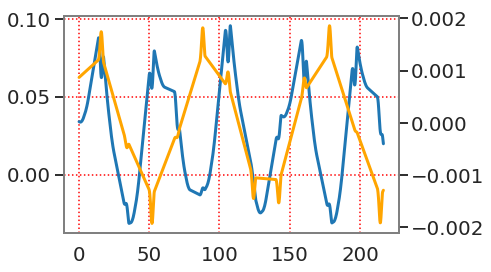

In [44]:
plt.plot(s_positions_all[0::2], x_pystl[0::2])
plt.twinx()
plt.grid(False)
plt.plot(s_positions_all[0::2], y_pystl[0::2], color='orange')

## run piecewise with `TrackSixTrackLib`

In [45]:
one_turn_map_sp = [m for m in one_turn_map if isinstance(m, TrackSixTrackLib)]
s_positions = np.cumsum([0] + list(m.length for m in one_turn_map if isinstance(m, SpaceChargePIC)))

In [46]:
D_x_0 = twiss['dx'][0] * beta
D_y_0 = twiss['dy'][0] * beta

np.random.seed(0)

pyht_beam = generate_Gaussian6DTwiss(
    n_macroparticles, intensity, e, m_p, circumference, gamma,
    twiss['alfx'][0], twiss['alfy'][0], twiss['betx'][0], twiss['bety'][0],
    beta_z, epsn_x, epsn_y, epsn_z, 
    dispersion_x=D_x_0 if D_x_0 else None,
    dispersion_y=D_y_0 if D_y_0 else None,
)

In [47]:
with GPU(pyht_beam):
    one_turn_map_sp[0].pyht_to_stlib(pyht_beam)

In [48]:
rec_x = np.empty(len(s_positions), dtype=float)
rec_y = np.empty_like(rec_x)

rec_x[0] = pyht_beam.x[0]
rec_y[0] = pyht_beam.y[0]

with GPU(pyht_beam):
    for i, m in enumerate(one_turn_map_sp):
        m.track(pyht_beam)
        context.synchronize()
        
        rec_x[i+1] = pyht_beam.x[0].get()
        rec_y[i+1] = pyht_beam.y[0].get()

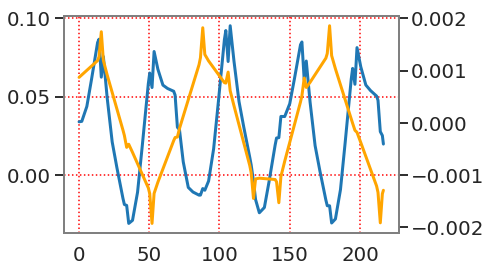

In [49]:
plt.plot(s_positions, rec_x)
plt.twinx()
plt.grid(False)
plt.plot(s_positions, rec_y, color='orange')

## comparison

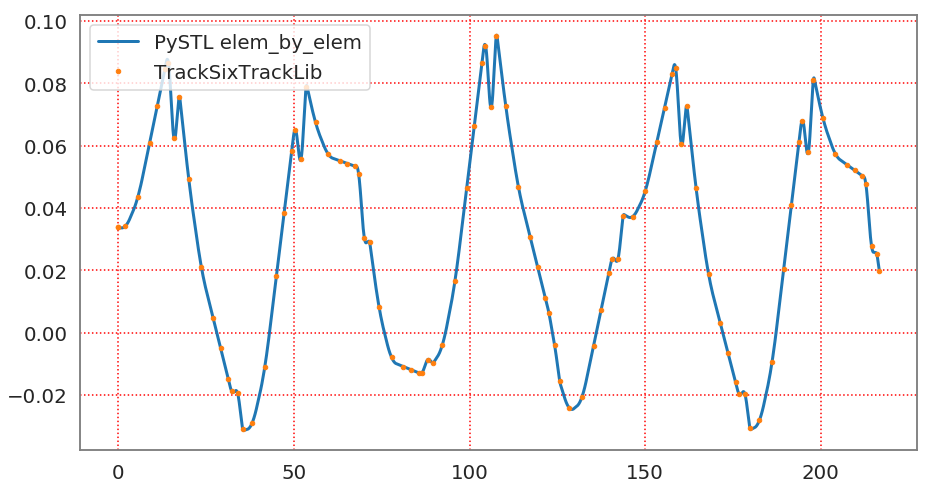

In [50]:
plt.figure(figsize=(15, 8))
plt.plot(s_positions_all[0::2], x_pystl[0::2], label='PySTL elem_by_elem')
plt.plot(s_positions, rec_x, '.', label='TrackSixTrackLib')
plt.legend();

# Timing for $10^4$ macro-particles

In [51]:
t0 = time.time()

with GPU(pyht_beam):
    for m in one_turn_map:
        m.track(pyht_beam)
    
t1 = time.time()

In [52]:
t1 - t0

2.408567428588867

In [53]:
with GPU(pyht_beam):
    stats = %prun -r -q   for m in one_turn_map: m.track(pyht_beam)

In [54]:
stats.sort_stats(2).print_stats(20)

         83793 function calls (83009 primitive calls) in 1.420 seconds

   Ordered by: cumulative time
   List reduced from 99 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.420    1.420 {built-in method builtins.exec}
        1    0.001    0.001    1.420    1.420 <string>:1(<module>)
       98    0.006    0.000    0.980    0.010 pypic_spacecharge.py:82(track)
       98    0.172    0.002    0.925    0.009 pypic.py:676(pic_solve)
       98    0.287    0.003    0.439    0.004 <ipython-input-28-2e4f057bb429>:22(track)
       98    0.000    0.000    0.366    0.004 pypic.py:537(poisson_solve)
       98    0.007    0.000    0.365    0.004 FFT_solver.py:382(poisson_solve)
       98    0.197    0.002    0.303    0.003 FFT_solver.py:375(_solve_kernel_fast)
       98    0.001    0.000    0.197    0.002 pypic.py:550(get_electric_fields)
      686    0.002    0.000    0.175    0.000 contextmanager.py:82(_patch

In [55]:
with GPU(pyht_beam):
    stats = %prun -r -q for m in one_turn_map_sp: m.track(pyht_beam)

In [56]:
stats.sort_stats(2).print_stats(20)

         2845 function calls (2257 primitive calls) in 0.367 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.367    0.367 {built-in method builtins.exec}
        1    0.000    0.000    0.367    0.367 <string>:1(<module>)
       98    0.230    0.002    0.367    0.004 <ipython-input-28-2e4f057bb429>:22(track)
       98    0.129    0.001    0.135    0.001 <ipython-input-28-2e4f057bb429>:33(pyht_to_stlib)
      588    0.005    0.000    0.006    0.000 <ipython-input-28-2e4f057bb429>:42(memcpy)
       98    0.002    0.000    0.002    0.000 trackjob.py:487(track_line)
 1176/588    0.000    0.000    0.001    0.000 {built-in method builtins.len}
      588    0.000    0.000    0.000    0.000 gpuarray.py:605(__len__)
       98    0.000    0.000    0.000    0.000 <ipython-input-28-2e4f057bb429>:49(stlib_to_pyht)
       98    0.000    0.000    0.000    0.000 trackjob.py:337(last_track_status_success)
 

.

.

.

============================================================================================================

$\implies$ `PySTL` single-particle tracking takes **0.37s** out of **1.4s**, the rest is due to `PyHEADTAIL` / `PyPIC` with the space charge kicks.

============================================================================================================

.

.

In [57]:
%load_ext line_profiler

In [58]:
with GPU(pyht_beam):
    stats = %lprun -r -f TrackSixTrackLib.track   for m in one_turn_map_sp: m.track(pyht_beam)

In [59]:
stats.print_stats()

Timer unit: 1e-06 s

Total time: 0.359431 s
File: <ipython-input-28-2e4f057bb429>
Function: track at line 22

Line #      Hits         Time  Per Hit   % Time  Line Contents
    22                                               def track(self, beam):
    23                                                   # pass arrays and convert units
    24        98     133615.0   1363.4     37.2          self.pyht_to_stlib(beam)
    25                                                   # track in SixTrackLib
    26        98        147.0      1.5      0.0          trackjob.track_line(self.i_start, self.i_end, 
    27        98       1745.0     17.8      0.5                              finish_turn=self.is_last_element)
    28        98     223221.0   2277.8     62.1          self.context.synchronize()
    29        98        284.0      2.9      0.1          assert trackjob.last_track_status_success
    30                                                   # pass arrays back (converting units back)
  

# Timing for $10^6$ instead of $10^4$ macro-particles

In [60]:
n_macroparticles = int(1e6)

In [61]:
D_x_0 = twiss['dx'][0] * beta
D_y_0 = twiss['dy'][0] * beta

np.random.seed(0)

pyht_beam = generate_Gaussian6DTwiss(
    n_macroparticles, intensity, e, m_p, circumference, gamma,
    twiss['alfx'][0], twiss['alfy'][0], twiss['betx'][0], twiss['bety'][0],
    beta_z, epsn_x, epsn_y, epsn_z, 
    dispersion_x=D_x_0 if D_x_0 else None,
    dispersion_y=D_y_0 if D_y_0 else None,
)

In [62]:
del trackjob, pyst_beam

In [63]:
pyst_beam = pyst.Particles.from_ref(num_particles=n_macroparticles, p0c=p0c)

In [64]:
trackjob = pyst.CudaTrackJob(elements, pyst_beam)

In [65]:
for m in one_turn_map_sp:
    m.trackjob = trackjob

In [66]:
with GPU(pyht_beam):
    stats = %prun -r -q   for m in one_turn_map: m.track(pyht_beam)

In [67]:
stats.sort_stats(2).print_stats(20)

         83793 function calls (83009 primitive calls) in 1.509 seconds

   Ordered by: cumulative time
   List reduced from 99 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.509    1.509 {built-in method builtins.exec}
        1    0.001    0.001    1.509    1.509 <string>:1(<module>)
       98    0.006    0.000    0.962    0.010 pypic_spacecharge.py:82(track)
       98    0.149    0.002    0.899    0.009 pypic.py:676(pic_solve)
       98    0.411    0.004    0.546    0.006 <ipython-input-28-2e4f057bb429>:22(track)
       98    0.000    0.000    0.385    0.004 pypic.py:537(poisson_solve)
       98    0.008    0.000    0.384    0.004 FFT_solver.py:382(poisson_solve)
       98    0.197    0.002    0.315    0.003 FFT_solver.py:375(_solve_kernel_fast)
      686    0.003    0.000    0.195    0.000 contextmanager.py:82(_patch_binop)
       98    0.001    0.000    0.177    0.002 pypic.py:550(get_electric_

In [68]:
with GPU(pyht_beam):
    stats = %prun -r -q for m in one_turn_map_sp: m.track(pyht_beam)

In [69]:
stats.sort_stats(2).print_stats(20)

         2845 function calls (2257 primitive calls) in 0.567 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.567    0.567 {built-in method builtins.exec}
        1    0.000    0.000    0.567    0.567 <string>:1(<module>)
       98    0.406    0.004    0.567    0.006 <ipython-input-28-2e4f057bb429>:22(track)
       98    0.152    0.002    0.158    0.002 <ipython-input-28-2e4f057bb429>:33(pyht_to_stlib)
      588    0.006    0.000    0.006    0.000 <ipython-input-28-2e4f057bb429>:42(memcpy)
       98    0.002    0.000    0.002    0.000 trackjob.py:487(track_line)
 1176/588    0.000    0.000    0.001    0.000 {built-in method builtins.len}
      588    0.000    0.000    0.001    0.000 gpuarray.py:605(__len__)
       98    0.000    0.000    0.000    0.000 <ipython-input-28-2e4f057bb429>:49(stlib_to_pyht)
       98    0.000    0.000    0.000    0.000 trackjob.py:337(last_track_status_success)
 

In [70]:
with GPU(pyht_beam):
    stats = %lprun -r -f TrackSixTrackLib.track   for m in one_turn_map_sp: m.track(pyht_beam)

In [71]:
stats.print_stats()

Timer unit: 1e-06 s

Total time: 0.569405 s
File: <ipython-input-28-2e4f057bb429>
Function: track at line 22

Line #      Hits         Time  Per Hit   % Time  Line Contents
    22                                               def track(self, beam):
    23                                                   # pass arrays and convert units
    24        98     157739.0   1609.6     27.7          self.pyht_to_stlib(beam)
    25                                                   # track in SixTrackLib
    26        98        165.0      1.7      0.0          trackjob.track_line(self.i_start, self.i_end, 
    27        98       1829.0     18.7      0.3                              finish_turn=self.is_last_element)
    28        98     409108.0   4174.6     71.8          self.context.synchronize()
    29        98        208.0      2.1      0.0          assert trackjob.last_track_status_success
    30                                                   # pass arrays back (converting units back)
  

.

.

.

============================================================================================================

$\implies$ `PySTL` single-particle tracking takes **0.57s** out of **1.5s**, the rest is due to `PyHEADTAIL` / `PyPIC` with the space charge kicks.

============================================================================================================

.

.